In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
ix = os.getcwd().index('umich-mads-capstone-project')
ROOT_PATH = os.path.join(os.getcwd()[:ix], 'umich-mads-capstone-project')

patient_data_path = os.path.join(ROOT_PATH, 'data/rsna/rsna-patient-details.csv')

df = pd.read_csv(patient_data_path)

In [6]:
df = df[df['patient_age'] <= 100]

In [8]:
def confusion(x):
  if x['target'] == 1 and x['rsna_densenet_proba'] >= 0.5:
    return 'TP'
  elif x['target'] == 0 and x['rsna_densenet_proba'] >= 0.5:
    return 'FP'
  elif x['target'] == 0 and x['rsna_densenet_proba'] < 0.5:
    return 'TN'
  elif x['target'] == 1 and x['rsna_densenet_proba'] < 0.5:
    return 'FN'

df['confusion'] = df.apply(lambda x: confusion(x), axis=1)

In [9]:
def age_bracket(x):
  if 0 <= x <= 1:
    return 'Infant 1 year-old'
  elif 2 <= x <= 5:
    return 'Preschool (2-5)'
  elif 6 <= x <= 12:
    return 'Child (6-12)'
  elif 13 <= x <= 18:
    return 'Adolescent (13-18)'
  elif 19 <= x <= 44:
    return 'Adult (19-44)'
  elif 45 <= x <= 64:
    return 'Middle Age (45-64)'
  elif 65 <= x <= 79:
    return 'Aged (45-64)'
  elif  x >= 80:
    return 'Aged (80+)'

df['age_bracket'] = df['patient_age'].apply(lambda x: age_bracket(x))

In [10]:
df.head()

,index,patient_id,patient_age,patient_sex,view_position,class,target,split,rsna_baseline_proba,rsna_densenet_proba,age_group,confusion,age_bracket
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,F,PA,No Lung Opacity / Not Normal,0,train,0.199968,0.272411,Middle age (45-64),TN,Middle Age (45-64)
1,1,000924cf-0f8d-42bd-9158-1af53881a557,19,F,AP,Normal,0,train,0.156917,0.031587,Adult (19-44),TN,Adult (19-44)
2,2,000db696-cf54-4385-b10b-6b16fbb3f985,25,F,AP,Lung Opacity,1,train,0.688685,0.698994,Adult (19-44),TP,Adult (19-44)
3,3,000fe35a-2649-43d4-b027-e67796d412e0,40,M,AP,Lung Opacity,1,train,0.943956,0.984925,Adult (19-44),TP,Adult (19-44)
4,4,001031d9-f904-4a23-b3e5-2c088acd19c6,57,M,PA,Lung Opacity,1,train,0.374111,0.407364,Middle age (45-64),FN,Middle Age (45-64)


([<matplotlib.axis.XTick at 0x7fbe1d6ad310>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

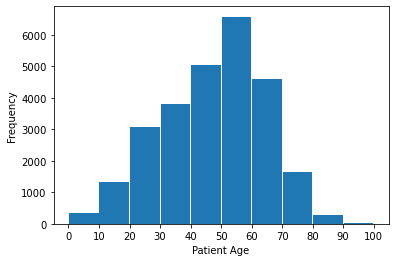

In [11]:
plt.hist(df['patient_age'], bins=[0,10,20,30,40,50,60,70,80,90,100], histtype='bar', rwidth=0.97)
plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 101, step=10))

In [12]:
class_df = df.value_counts('class')
class_df.head()

class
No Lung Opacity / Not Normal    11819
Normal                           8848
Lung Opacity                     6012
dtype: int64

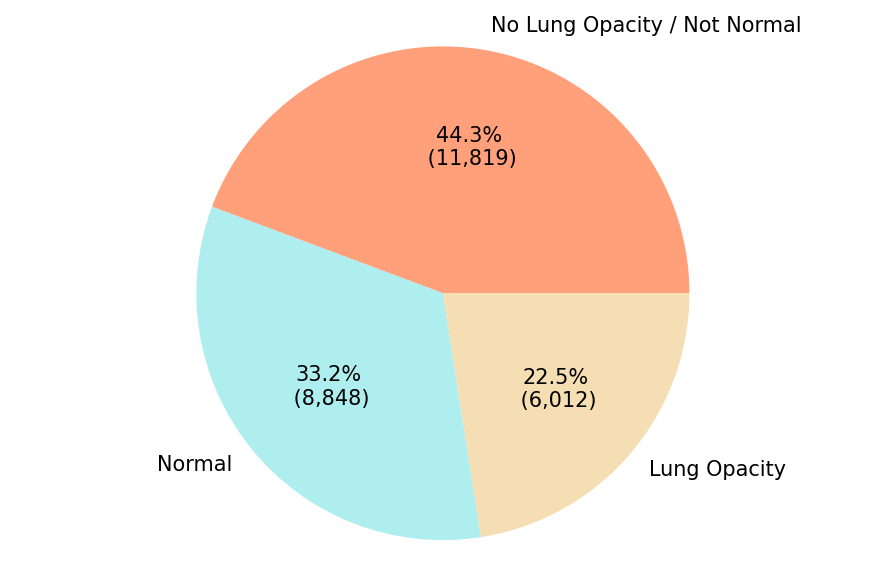

In [14]:
labels = class_df.index
sizes = class_df.values
total = sum(sizes)

def perc(p, total):
  return '{:.1f}%\n ({:,.0f})'.format(p, p * total / 100)

plt.figure(dpi=150)
plt.pie(sizes, labels=labels, autopct=lambda p: perc(p, total), colors=['lightsalmon','paleturquoise','wheat'])
plt.axis('equal')
plt.tight_layout()

In [15]:
confusion_df = df.value_counts('confusion')
confusion_df.head()

confusion
TN    19140
TP     3920
FN     2092
FP     1527
dtype: int64

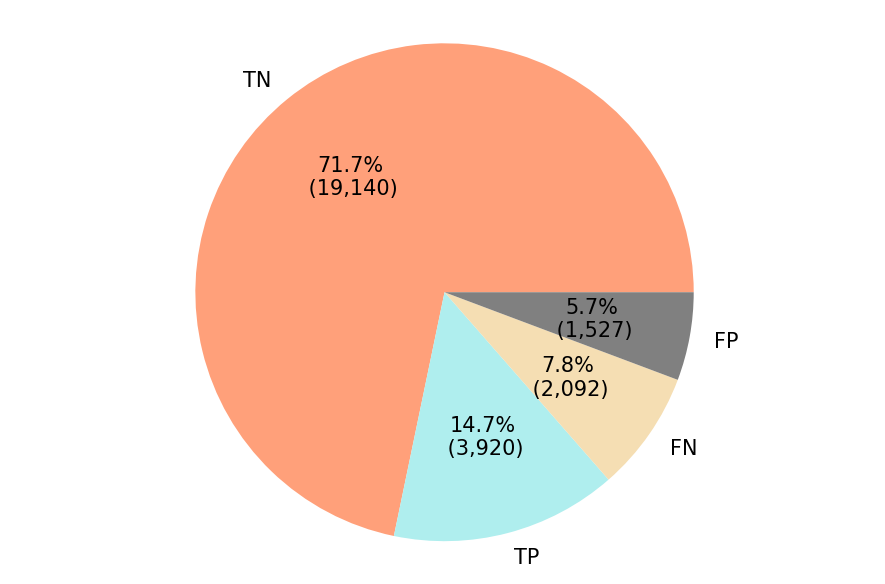

In [17]:
labels = confusion_df.index
sizes = confusion_df.values
plt.figure(dpi=150)
plt.pie(sizes, labels=labels, autopct=lambda p: perc(p, total), colors=['lightsalmon','paleturquoise','wheat', 'grey'])
plt.axis('equal')
plt.tight_layout()

In [18]:
grp_df = df.groupby(by=['age_bracket','patient_sex','confusion'], as_index=False).count()
grp_df = grp_df[['age_bracket','patient_sex','confusion','index']]
#grp_df.head()

In [19]:
pvt_df = grp_df.pivot(index=['age_bracket','patient_sex'], columns='confusion', values='index')
pvt_df.reset_index(inplace=True)
#pvt_df.head()

In [20]:
def precision(x):
  return x['TP'] / (x['TP'] + x['FP'])

def recall(x):
  return x['TP'] / (x['TP'] + x['FN'])

def f1(x):
  return 2 * ((x['Precision'] * x['Recall'])/(x['Precision'] + x['Recall']))

pvt_df['Precision'] = pvt_df.apply(lambda x: precision(x), axis=1)
pvt_df['Recall'] = pvt_df.apply(lambda x: recall(x), axis=1)
pvt_df['F1 Score'] = pvt_df.apply(lambda x: f1(x), axis=1)

In [30]:
pvt_df.head()

confusion,age_bracket,patient_sex,FN,FP,TN,TP,Precision,Recall,F1 Score
0,Adolescent (13-18),F,38.0,13.0,209.0,49.0,0.790323,0.563218,0.657718
1,Adolescent (13-18),M,70.0,36.0,348.0,85.0,0.702479,0.548387,0.615942
2,Adult (19-44),F,384.0,192.0,3069.0,501.0,0.722944,0.566102,0.634981
3,Adult (19-44),M,549.0,281.0,3589.0,808.0,0.741965,0.595431,0.660670
4,Aged (45-64),F,161.0,84.0,1088.0,178.0,0.679389,0.525074,0.592346


([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text major ticklabel objects>)

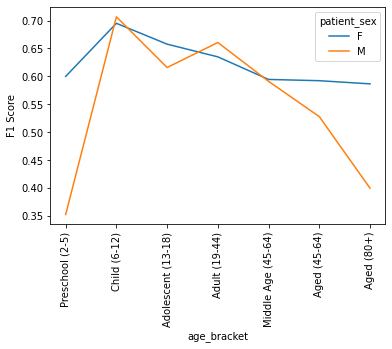

In [46]:
ages = ['Infant 1 year-old','Preschool (2-5)','Child (6-12)','Adolescent (13-18)','Adult (19-44)','Middle Age (45-64)','Aged (45-64)','Aged (80+)']
pvt_df = pvt_df.set_index('age_bracket')
pvt_df = pvt_df.loc[ages]
pvt_df.reset_index(inplace=True)


#display(pvt_df)
sns.lineplot(data=pvt_df, x='age_bracket', y='F1 Score', hue='patient_sex', sort=False)
plt.xticks(rotation=90)